# Damage model 
The original model is 

\begin{equation}\label{eq: original model}
y^*  = y \cdot I\{c \cdot y > l\} + \alpha \cdot y \cdot I\{c \cdot y < l\}
\end{equation}



# Smooth function

Note that we have the indicator function in the model we might consider the smooth function:
\begin{equation}\label{eq: trans function}
S(x;s) = \frac{1}{1 + \exp(-s \cdot x)}
\end{equation},
where $s$ is the smoothing hyper-parameter to control the smoothness. 

Then the model becomes 
$$
y^*  = y \cdot \frac{1}{1 + \exp(-s\cdot(cy-l))} + \alpha \cdot y \cdot \frac{1}{1 + \exp(-s\cdot(l-cy))}
$$

We have $y \geq y^*$.

The lumber have three groups:

- Group 1: $y <l$, $y^* < l$, i.e., $y^* <y < l$. The lumber pieces are broken blow the proof loading.
- Group 2: $y >l$, $y^* < l$, i.e. $y^*<l<y$. The lumber pieces are broken during the proof loading process. This groups we only knows how many pieces. 

update: this group should be $0<y^*<l<y$. So $F_y(h^{-1}(l)) - F_y(h^{-1}(\max(0,h^{-1}(l)))$
- Group 3: $y >l$, $y^* > l$, i.e. $l<y^*<y$. The lumber pieces survived in the proof-loading. And then we destruct them to test their strength.


# The PDF calculation 

Given $Y \sim N(\mu, \sigma^2)$, $Y^* = h(Y)$. Then the pdf of $Y^*$,
$$
f_{Y^*}(y^*) = f_{Y}(h^{-1}(y^*))|\frac{d}{dy^*}h^{-1}(y^*)|,
$$
where $f_Y()$ is the pdf of $Y$, i.e., normal. 

Following this, We need the numerical function of $h^{-1}(y^*)$, and its numerical gradient $\frac{d}{dy^*}h^{-1}(y^*)$. (The analytical form doesn't seem available.)

# The range of alpha

For the model 

\begin{equation}
y^*  = y \cdot I\{c \cdot y > l\} + \alpha \cdot y \cdot I\{c \cdot y < l\}.
\end{equation}

What happened if $\alpha < c$?

then $\alpha*y < c*y <l $. It means that all damaged pieces are censored. So we don't have damaged pieces. The remaining pieces in group 3 are all undamaged. Then we can only have the range of $\alpha$ but no specific estimate.

In bivarite dataset, we don't have this problem because we have $c*x$ and $\alpha*y$.

# Truncated normal

If $\alpha < c$, it mean that the whole groups are undamaged, which should follow the truncated normal $TN(l/c, \inf, \mu,\sigma)$.

If x comes from the truncated normal, we denote $x \sim TN(a,b,\mu,\sigma)$, where the original distribution is $N(\mu,\sigma)$ but truncated in the interval $[a,b]$. The package ``scipy.stats.truncnorm`` can calculate the mean and variance of the distribution $TN(a,b,\mu,\sigma)$, denoted as $\mu_T$ and $\sigma^2_{T}$. 

Further, if the samples $x_1,...,x_N$ come from $x \sim TN(a,b,\mu,\sigma)$, the sample mean $\bar x$ asymptotically follows the normal distrbution of mean $mu_T$ and variance $\sigma^2_T/N$ (by central limit theorem).


# Hypothesis testing

Now according to the model, $\alpha$ cannot be estimated if $\alpha\leq c$;$\alpha$ can be estimated if $\alpha>c$; 



So $H_0:\alpha\leq c$, and $H_A: \alpha>c$. 


Under $H_0$, the data in the group3, should follow $TN(l/c, \inf, \mu,\sigma)$, of which the mean if $\mu_T$. Thus we can test whether the mean of group 3, denoted as $\mu_{g3}$ is  $\mu_T$ ($\mu_{g3} = \mu_T$?).


Test statistics:

\begin{equation}
z = \frac{\mu_{g3} - E[TN(l/\hat{c},\inf,\hat\mu,\hat\sigma)]}{\sqrt{Var[TN(l/\hat{c},\inf,\hat\mu,\hat\sigma)]/N_{g3}}} \sim N(0,1)
\end{equation}

And p value is $\Phi(z)$, where $\Phi$ is the standard normal cdf function. If p-value < 0.05, it means the damage effect is significant. Otherwise, it is insignificant.


In [541]:
import jax
import jaxopt
import jax.numpy as jnp
import pyreadr
import projplot as pjp


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import scipy
import numpy as np

In [542]:
@jax.jit

def indicator(x):
    return(jnp.select([x>0,x<=0],[1,0]))

def logit(x):
    return(jnp.log(x/(1-x)))


def expit(x):
    return 1/(1+jnp.exp(-x))

def exp_smooth(x):
    return(jnp.select(
    [x >0, x<=0],[jnp.exp(-1/(x+ 0.001)),0]))

def g_smooth(x):
    return(exp_smooth(x)/(exp_smooth(x) + exp_smooth(1-x)))

def sigmoid(x, s):
    # x = jnp.array(x)
    # a = jnp.array(a)
    return 0.5 * (jnp.tanh(x * s / 2) + 1)

def dmgmodel_ind(y,alpha,l,c):
    return(y*indicator(c*y-l) + alpha*y*indicator(l-c*y))


def dmgmodel_py(y,alpha,l,c,s):
    #return(y*jax.scipy.stats.norm.cdf(c*y-l) + alpha*y*jax.scipy.stats.norm.cdf(l-c*y))
    return(y*sigmoid(c*y-l,s) + alpha*y*sigmoid(l-c*y,s))

    #return(y*g_smooth(c*y-l) + alpha*y*g_smooth(l-c*y))

def dmgmodel_root_py(y,alpha,l,c,s,ystar):
    return(dmgmodel_py(y,alpha,l,c,s) - ystar)



def dmginverse_py(ystar,alpha,l,c,s):
    """
    Calculate the root of `Teqn()`.
    """
    def root_fun(y):
        return dmgmodel_root_py(y = y,alpha = alpha,l = l,
                                c = c,s = s,ystar = ystar)

    def solve(root_fun, Ts_init):
        bisec = jaxopt.Bisection(
            optimality_fun=root_fun,
            lower = 0,
            upper = 10000,
            check_bracket=False
        )
        return bisec.run().params

    def tangent_solve(g, y):
        return y/g(1.0)

    return jax.lax.custom_root(
        f=root_fun,
        initial_guess=50., # dummy value
        solve=solve,
        tangent_solve=tangent_solve,
        has_aux=False   # could set this to True if we wanted to return convergence results from `bisec.run()`
    )

def dmginvgrad_py(ystar,alpha,l,c,s):
    grad_func = jax.grad(dmginverse_py,0)
    return(jnp.abs(grad_func(ystar,alpha,l,c,s)))

def dmglik_py(ystar,alpha,l,c,s,mu,sigma):
    y =  dmginverse_py(ystar,alpha,l,c,s)
    return(jax.scipy.stats.norm.logpdf(y,loc = mu,scale = sigma)+ 
           jnp.log(dmginvgrad_py(ystar,alpha,l,c,s))
          )


def dmglik_vmap(y_group,alpha,l,c,s,mu,sigma):
    y_group = jnp.array(y_group)
    lik = jax.vmap(lambda y_group: dmglik_py(ystar = y_group,
                                             alpha = alpha,l = l, c= c,s =s,mu = mu, sigma=sigma))(y_group)
    return(jnp.sum(lik))



# In the first case, $\alpha >c$

In [543]:
# the orignal sample size 
#N = 30000
N = 300
mu = 48
sigma = 19
l =  32
alpha = 0.5
c = 0.7
s = 0.8
N_marginal = 139





In [544]:
# data generation 
key = jax.random.PRNGKey(3)
subkeys = jax.random.split(key, num=N)

y = sigma*jax.random.normal(subkeys[0], shape=(N, )) + mu

#y = y[y>0]

# g1
y_obs_g1  = y[y<l]


# g23_star
g23 = y[y>l]
#g23_star = jax.vmap(lambda y: dmgmodel_ind(y,alpha,l,c))(g23)

g23_star = jax.vmap(lambda y: dmgmodel_py(y,alpha,l,c,s))(g23)



# g3
y_obs_g3 = g23_star[g23_star > l]

# g2
y_obs_g2 = N - len(y_obs_g1) - len(y_obs_g3)

#y_obs_g2 = jnp.shape(y)[0] - len(y_obs_g1) - len(y_obs_g3)

# g4, is all marginal data
y_obs_g4 = sigma*jax.random.normal(subkeys[0], shape=(N_marginal, )) + mu

In [545]:
# # 0 if nondamage, 1 if damaged
# #dmg_con = jnp.where(g23 == g23_star,0,1)

# dmg_con = jnp.vstack((g23,g23_star,jnp.where(g23 == g23_star,0,1))).T
# dmg_con[dmg_con[:,1] > l,:]


In [546]:
#s = 10
l = l 
y_obs_g1 = y_obs_g1
y_obs_g2 = y_obs_g2
y_obs_g3 = y_obs_g3
y_obs_g4 = y_obs_g4
@jax.jit
def negdmglik_jax(theta):
    mu = theta[0]
    sigma = theta[1]
    alpha = theta[2]
    c = theta[3]
    s = theta[4]
    lik1 = jnp.sum(jax.scipy.stats.norm.logpdf(y_obs_g1,loc = mu, scale = sigma))
    #lik1 = dmglik_vmap(y_group = y_obs_g1,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
#     lik2 = y_obs_g2*jnp.log(
#         jax.scipy.stats.norm.cdf(dmginverse_py(l,alpha,l,c,s), loc=mu, scale=sigma) - 
#         jax.scipy.stats.norm.cdf(l, loc=mu, scale=sigma)
#     )
    lik2 = y_obs_g2*jnp.log(
    jax.scipy.stats.norm.cdf(dmginverse_py(l,alpha,l,c,s), loc=mu, scale=sigma) - 
    jax.scipy.stats.norm.cdf(dmginverse_py(jnp.maximum(0.1,dmgmodel_py(l,alpha,l,c,s)),alpha,l,c,s), loc=mu, scale=sigma)
    )
    lik3 = dmglik_vmap(y_group = y_obs_g3,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
    lik4 = jnp.sum(jax.scipy.stats.norm.logpdf(y_obs_g4,loc = mu, scale = sigma))

    return(-lik1 - lik2-lik3-lik4)

theta0 = jnp.array([mu,sigma,alpha,c,s])



negdmglik_jax(theta0)

Array(1811.5883, dtype=float32)

In [547]:
theta_init = jnp.array([mu,sigma,c,c,s])

solver = jaxopt.ScipyMinimize(method = "Nelder-Mead",fun=negdmglik_jax)
res = solver.run(theta0)

# solver = jaxopt.BFGS(fun=negdmglik_jax)
# res = solver.run(theta0)

res.params,res.state
theta0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:549: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


(Array([47.76771   , 20.23599   ,  0.25349006,  0.738148  ,  1.0165846 ],      dtype=float32),
 ScipyMinimizeInfo(fun_val=Array(1808.2527, dtype=float32), success=True, status=0, iter_num=105))

Array([48. , 19. ,  0.5,  0.7,  0.8], dtype=float32)

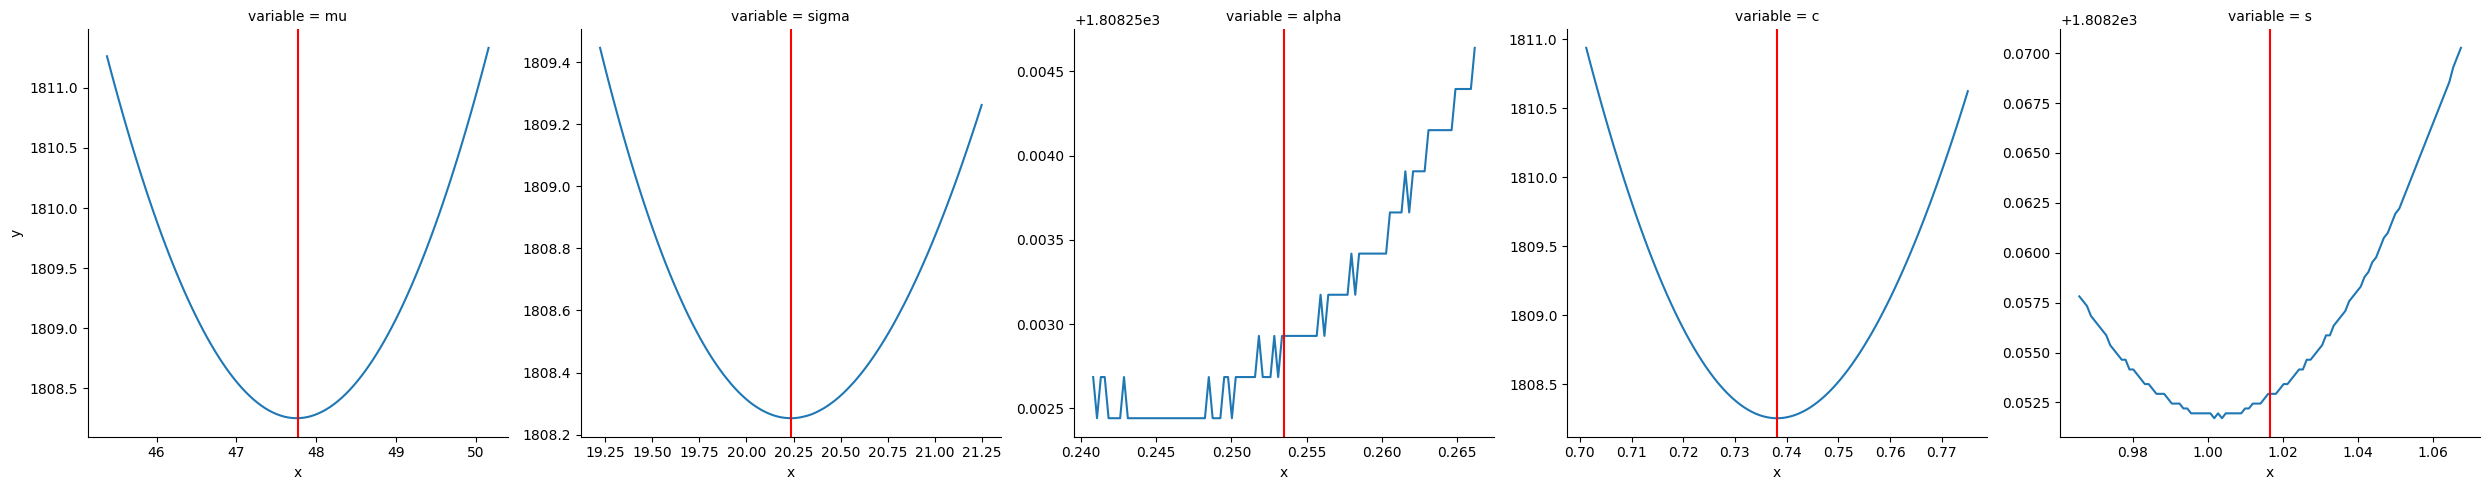

In [548]:
xsol = res.params
xrange = .05
theta_upper = xsol  + xrange *jnp.abs(xsol)
theta_lower = xsol - xrange * jnp.abs(xsol)
theta_rng_trans = jnp.array([theta_lower, theta_upper])
theta_rng = jnp.transpose(theta_rng_trans)

#theta_rng = theta_rng.at[2,:].set(jnp.array([.05,.7]))
# plot at the true value theta0
pjp.proj_plot(
    fun=negdmglik_jax,
    x_opt=xsol,
    x_lims=theta_rng, 
    x_names = ['mu','sigma','alpha','c','s'],
    n_pts=100, 
    opt_vlines=True
)

change $s = 10$ to $s =1$ can make loglik of alpha and c more smooth.

In [549]:
trunc_mean = scipy.stats.truncnorm.mean((l/res.params[3] -res.params[0])/res.params[1] , 
                                         float("inf"), loc=res.params[0], scale=res.params[1])
trunc_var = scipy.stats.truncnorm.var((l/res.params[3] -res.params[0])/res.params[1] , 
                                         float("inf"), loc=res.params[0], scale=res.params[1])

sample_mean = trunc_mean
sample_var = trunc_var/y_obs_g3.shape[-1]


test_stat = (np.mean(y_obs_g3) - sample_mean)/np.sqrt(sample_var)
scipy.stats.norm.cdf(test_stat)

0.3131142379909513

In [550]:
np.min(y_obs_g3)
l/c

Array(32.015335, dtype=float32)

45.714285714285715

# In the second case, $\alpha <c$

In [9]:
# the orignal sample size 
#N = 30000
N = 300
mu = 48
sigma = 19
l =  32
# alpha = 0.6
# c = 0.65
alpha = 0.65
c = 0.68
s = 10

N_marginal = 139





In [10]:
# data generation 
key = jax.random.PRNGKey(0)
subkeys = jax.random.split(key, num=N)

y = sigma*jax.random.normal(subkeys[3], shape=(N, )) + mu

#y = y[y>0]

# g1
y_obs_g1  = y[y<l]


# g23_star
g23 = y[y>l]
g23_star = jax.vmap(lambda y: dmgmodel_py(y,alpha,l,c,s))(g23)


# g3
y_obs_g3 = g23_star[g23_star > l]

# g2
y_obs_g2 = N - len(y_obs_g1) - len(y_obs_g3)

#y_obs_g2 = jnp.shape(y)[0] - len(y_obs_g1) - len(y_obs_g3)

# g4, is all marginal data
y_obs_g4 = sigma*jax.random.normal(subkeys[0], shape=(N_marginal, )) + mu

In [11]:
# negdmglik_jax(theta0)
#dmglik_vmap(y_group = y_obs_g3,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)

#dmglik_py(y_obs_g3[0][0],alpha,l,c,s,mu,sigma)

#dmglik_vmap(y_obs_g3,alpha,l,c,s,mu,sigma)

s= 10
l = l 
y_obs_g1 = y_obs_g1
y_obs_g2 = y_obs_g2
y_obs_g3 = y_obs_g3
y_obs_g4 = y_obs_g4
@jax.jit
def negdmglik_jax(theta):
    mu = theta[0]
    sigma = theta[1]
    alpha = theta[2]
    c = theta[3]
    lik1 = jnp.sum(jax.scipy.stats.norm.logpdf(y_obs_g1,loc = mu, scale = sigma))
    #lik1 = dmglik_vmap(y_group = y_obs_g1,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
#     lik2 = y_obs_g2*jnp.log(
#         jax.scipy.stats.norm.cdf(dmginverse_py(l,alpha,l,c,s), loc=mu, scale=sigma) - 
#         jax.scipy.stats.norm.cdf(l, loc=mu, scale=sigma)
#     )
    lik2 = y_obs_g2*jnp.log(
    jax.scipy.stats.norm.cdf(dmginverse_py(l,alpha,l,c,s), loc=mu, scale=sigma) - 
    jax.scipy.stats.norm.cdf(dmginverse_py(jnp.maximum(0.1,dmgmodel_py(l,alpha,l,c,s)),alpha,l,c,s), loc=mu, scale=sigma)
    )
    lik3 = dmglik_vmap(y_group = y_obs_g3,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
    lik4 = jnp.sum(jax.scipy.stats.norm.logpdf(y_obs_g4,loc = mu, scale = sigma))

    return(-lik1 - lik2-lik3-lik4)

theta0 = jnp.array([mu,sigma,alpha,c])



negdmglik_jax(theta0)

Array(1684.0115, dtype=float32)

In [12]:
theta0 = jnp.array([mu,sigma,alpha,c])

solver = jaxopt.ScipyMinimize(method = "Nelder-Mead",fun=negdmglik_jax)
res = solver.run(theta0)

# solver = jaxopt.BFGS(fun=negdmglik_jax)
# res = solver.run(theta0)

res.params,res.state
theta0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:549: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


(Array([46.93917   , 19.66352   ,  0.64550763,  0.67717165], dtype=float32),
 ScipyMinimizeInfo(fun_val=Array(1682.5938, dtype=float32), success=True, status=0, iter_num=66))

Array([48.  , 19.  ,  0.65,  0.68], dtype=float32)

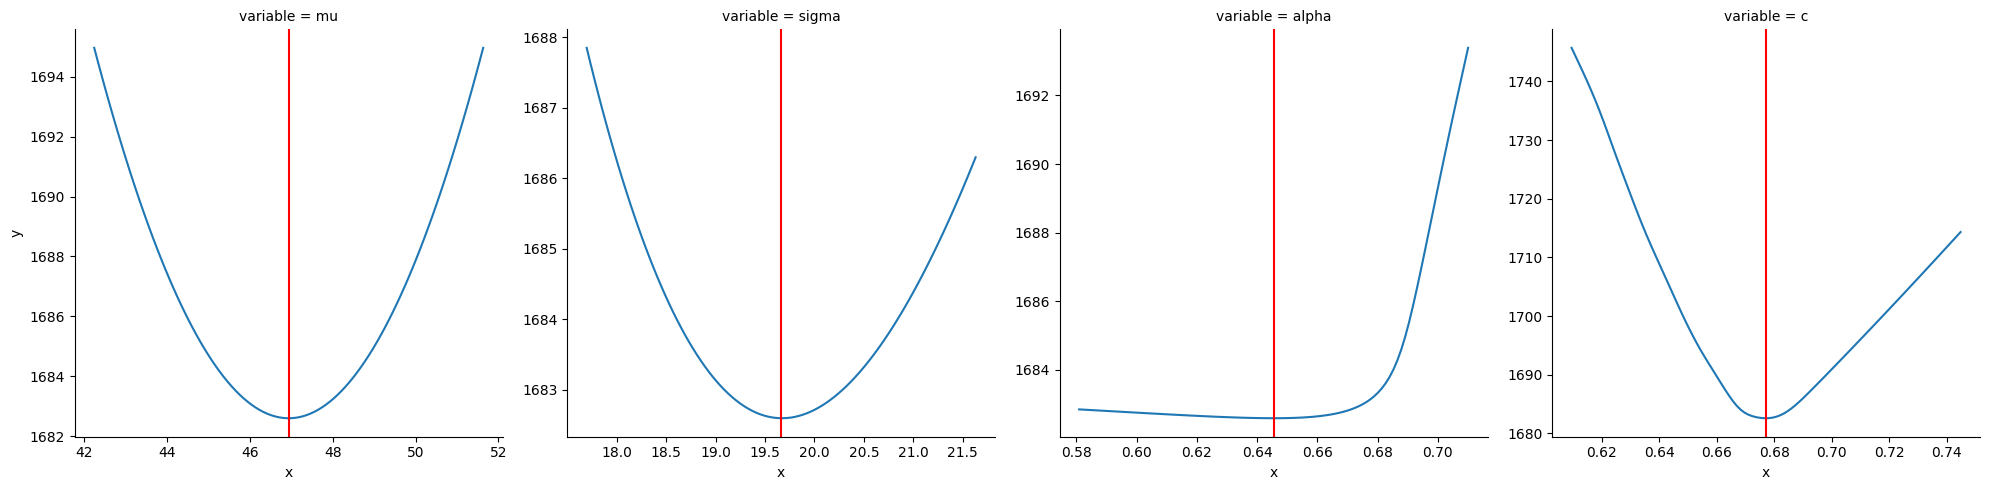

In [13]:
xsol = res.params
xrange = .1
theta_upper = xsol  + xrange *jnp.abs(xsol)
theta_lower = xsol - xrange * jnp.abs(xsol)
theta_rng_trans = jnp.array([theta_lower, theta_upper])

#res.params
theta_rng = jnp.transpose(theta_rng_trans)
#theta_rng = theta_rng.at[2,:].set(jnp.array([0.1,0.9]))
# plot at the true value theta0
pjp.proj_plot(
    fun=negdmglik_jax,
    x_opt=xsol,
    x_lims=theta_rng, 
    x_names = ['mu','sigma','alpha','c'],
    n_pts=100, 
    opt_vlines=True
)

In [14]:
trunc_mean = scipy.stats.truncnorm.mean((l/res.params[3] -res.params[0])/res.params[1] , 
                                         float("inf"), loc=res.params[0], scale=res.params[1])
trunc_var = scipy.stats.truncnorm.var((l/res.params[3] -res.params[0])/res.params[1] , 
                                         float("inf"), loc=res.params[0], scale=res.params[1])

sample_mean = trunc_mean
sample_var = trunc_var/y_obs_g3.shape[-1]


test_stat = (np.mean(y_obs_g3) - sample_mean)/np.sqrt(sample_var)
scipy.stats.norm.cdf(test_stat)

0.344310892705443